In [1]:
import clean_data_svi as cds
import supervised as sup
import pathlib
import keras_model as km
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error, roc_curve, auc, f1_score, precision_recall_curve, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

Using TensorFlow backend.


In [2]:
SVI_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/svi_{i+1}.csv", index_col="date")
    df = df.drop(columns=['Settling_velocity', 'SV_label', 'SVI_label'])
    df.index = pd.to_datetime(df.index, dayfirst=True)
    SVI_list.append(df)

In [3]:
temp_df = pd.read_csv("clean_tables/temperatur.csv", index_col="date")
temp_df.index = pd.to_datetime(temp_df.index, dayfirst=True)
sludge_age_df = pd.read_csv("clean_tables/sludge_age_f_m.csv", index_col="date")
sludge_age_df.index = pd.to_datetime(sludge_age_df.index, dayfirst=True)

In [4]:
reactor_list = []
for i in range(4):
    join = pd.concat([SVI_list[i], temp_df], axis=1)
    if i <=1:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[0, 2]]], axis=1)
    else:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[1, 3]]], axis=1)
    join.columns = ['SVI', 'Temperature', 'F_M', 'Sludge Age']
    reactor_list.append(join)

In [5]:
reactor_list[2]

,SVI,Temperature,F_M,Sludge Age
date,,,,
2010-01-01,94.066570,22.030,0.22,2.92
2010-01-02,95.318860,21.985,0.22,3.04
2010-01-03,82.826748,21.740,0.22,3.00
2010-01-04,95.307918,21.815,0.22,2.97
2010-01-05,93.930636,21.890,0.23,2.94
...,...,...,...,...
2020-12-27,144.736842,22.540,0.23,3.41
2020-12-28,130.890052,22.535,0.24,3.10
2020-12-29,140.306122,22.660,0.25,3.15


In [6]:
micro_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/micro_{i+1}.csv", index_col="date")
    df.index = pd.to_datetime(df.index, dayfirst=True)
    micro_list.append(df)

In [7]:
micro_list[0]

,arcella,nude ameba,aspidisca,trachelopylum,lionutus,paramecium,carchecium,epistylis,opercularia,podophyra,...,Floc Strength,Indian Ink,Filament index,Floc_size_small,Floc_size_medium,Floc_size_large,Shape_close,Shape_open,Filaments_in_floc,Free_filaments
date,,,,,,,,,,,,,,,,,,,,,
2010-02-18,40.0,4.0,2.0,0.0,6.0,0.0,1.0,4.0,4.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2010-03-02,27.0,5.0,3.0,1.0,16.0,0.0,0.0,13.0,4.0,0.0,...,NaN,NaN,3.0,NaN,NaN,NaN,0.0,1.0,1.0,0.0
2010-03-08,27.0,8.0,14.0,1.0,9.0,1.0,0.0,11.0,9.0,0.0,...,NaN,NaN,3.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0
2010-03-18,11.0,12.0,2.0,0.0,16.0,0.0,0.0,7.0,0.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2010-04-08,12.0,6.0,10.0,0.0,13.0,1.0,0.0,1.0,1.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-23,5.0,11.0,9.0,2.0,5.0,0.0,0.0,6.0,0.0,3.0,...,3.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-10-21,7.0,57.0,55.0,0.0,12.0,0.0,14.0,26.0,0.0,0.0,...,1.0,3.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-10-28,14.0,20.0,1.0,0.0,24.0,0.0,0.0,35.0,2.0,0.0,...,2.0,3.0,2.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [8]:
join_list = []
for i in range(4):
    join = pd.concat([reactor_list[i], micro_list[i]], axis=1)
    join_list.append(join)

In [9]:
join_list[1]

,SVI,Temperature,F_M,Sludge Age,arcella,nude ameba,aspidisca,trachelopylum,lionutus,paramecium,...,Floc Strength,Indian Ink,Filament index,Floc_size_small,Floc_size_medium,Floc_size_large,Shape_close,Shape_open,Filaments_in_floc,Free_filaments
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,88.649852,22.030,0.23,3.44,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,86.480363,21.985,0.18,3.78,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,96.370968,21.740,0.21,3.82,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,109.427609,21.815,0.21,3.40,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,100.929054,21.890,0.23,3.70,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,159.420290,22.540,0.25,2.75,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,147.887324,22.535,0.26,2.91,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-29,152.173913,22.660,0.26,2.82,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
X, Y = km.create_join_x_y_arr(join_list, n_steps_in=7, binary=True)

In [11]:
X

array([[[ 90.94368341,  22.03      ,   0.23      , ...,          nan,
                  nan,          nan],
        [ 84.36532508,  21.985     ,   0.18      , ...,          nan,
                  nan,          nan],
        [ 94.54113924,  21.74      ,   0.21      , ...,          nan,
                  nan,          nan],
        ...,
        [107.93768546,  21.89      ,   0.23      , ...,          nan,
                  nan,          nan],
        [ 89.8744113 ,  21.73      ,   0.2       , ...,          nan,
                  nan,          nan],
        [ 94.62809917,  21.655     ,   0.21      , ...,          nan,
                  nan,          nan]],

       [[ 84.36532508,  21.985     ,   0.18      , ...,          nan,
                  nan,          nan],
        [ 94.54113924,  21.74      ,   0.21      , ...,          nan,
                  nan,          nan],
        [ 97.4025974 ,  21.815     ,   0.21      , ...,          nan,
                  nan,          nan],
        ...,


In [12]:
X.shape

(16044, 7, 41)

In [13]:
X_normalize, Y_normalize, scalers = km.normalize(X, Y)

100%|██████████| 7/7 [00:00<00:00, 64.22it/s]


In [14]:
X_normalize = np.nan_to_num(X_normalize, nan=-1)

In [15]:
X[0]

array([[0.17449926, 0.37586548, 0.3255814 , 0.27717391,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan],
       [0.15989432, 0.37289812, 0.20930233, 0.32336957,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        

In [16]:
Y_normalize.shape

(16044, 1)

In [18]:
#start here
Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.10, random_state=42)
model = Sequential()
model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
model.fit(Xtrain, ytrain, epochs=3, batch_size=10, shuffle=True)

Epoch 1/3
14439/14439 [==============================] - 15s 1ms/step - loss: 0.5687 - binary_accuracy: 0.6877
Epoch 2/3
14439/14439 [==============================] - 13s 910us/step - loss: 0.4482 - binary_accuracy: 0.7356
Epoch 3/3
14439/14439 [==============================] - 15s 1ms/step - loss: 0.4206 - binary_accuracy: 0.7612


In [19]:
Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)

In [20]:
Yhat

array([[0.93607044],
       [0.985185  ],
       [0.9919107 ],
       ...,
       [0.9921839 ],
       [0.93872905],
       [0.9428058 ]], dtype=float32)

In [21]:
Ytest

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [43]:
y_real = Ytest.astype(int)

In [44]:
def threshold_for_max_f1(y_real, Yhat):
    '''
    Given inputs y_real and y_predict, the function returns
    the threshold (rounded to the nearest hundredth) that
    maximizes f1.
    
    Note: this funcnot necessarily optimized, could return to 
    doing this).
    '''
    f1_vals = []
    for i in range(1, 100):
        threshold = i/100
        y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
        y_real = Ytest.astype(int)
        
        f1 = km.results(y_real, y_predict, binary=True)[3]
        f1_vals.append(f1)
        
    return (f1_vals.index(max(f1_vals))+1)/100

In [45]:
threshold = threshold_for_max_f1(y_real, Yhat)
y_predict = np.where(Yhat > threshold, 1, 0).astype(int)

In [46]:
classes = ['High_svi', 'Low_svi']

In [47]:
cm = confusion_matrix(y_real, y_predict)

Confusion matrix, without normalization
[[364 148]
 [134 959]]


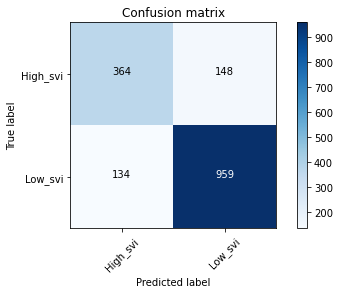

In [48]:
sup.plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [49]:
results = km.results(y_real, y_predict, binary=True)

In [50]:
results #accuracy, recall, precision, f1

(0.8242990654205608, 0.7109375, 0.7309236947791165, 0.7207920792079208)

In [51]:
fpr, tpr, thresholds = roc_curve(Ytest, Yhat)

In [52]:
auc(fpr, tpr)

0.8833342863677951

Text(0.5, 1.0, 'ROC curve')

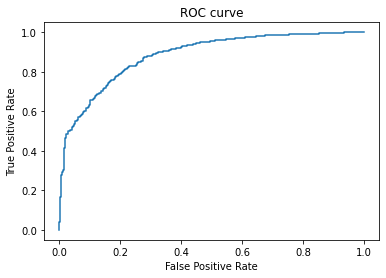

In [53]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

In [54]:
model_names = {1: 'Ball Simple LSTM',
                   2: 'Stacked LSTM',
                   3: 'Bidirectional LSTM',
                   4: 'CNN',
                   5: 'CNN LSTM',
                   6: 'LSTM Autoencoder',
                   7: 'Deep CNN',
                   8: 'GRU',
                   9: 'GRU CNN'}

def plot_graphs_metrics(model, results_list, steps_in, steps_out):
    model_name = model_names[model]
    
    #plot graph of a metric result for all n_step_in and n_step_out values
    x=list(range(1, steps_out))
    label = ['accuracy', 'TNR', 'NPV', 'f1']
    for z in range(4):
        for i in range(steps_in-1):
            y=[]
            for j in range(steps_out-1):
                y.append(results_list[i*(steps_out-1):i*(steps_out-1) + (steps_out-1)][j][z])
            plt.plot(x, y, label=f'n_steps_in={i+1}')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("n_steps_out")
        plt.ylabel(label[z])
        #change Simple LSTM to a variable
        plt.title(model_name + ", 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' ")
        #change Simple LSTM to a variable
        plt.savefig(f"figures/{model_name} {label[z]}.png", bbox_inches="tight")
        plt.close()    
    
    #plot graph of all metric results for a n_step_in value
    x=list(range(1, steps_out))
    label = ['accuracy', 'TNR', 'NPV', 'f1']
    for z in range(steps_in-1):
        for i in range(4):
            y=[]
            for j in range(steps_out-1):
                y.append(results_list[z*(steps_out-1):z*(steps_out-1)+(steps_out-1)][j][i])
            plt.plot(x, y, label=label[i])
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("n_steps_out")
        plt.ylabel('Metric value')
        #change Simple LSTM to a variable
        plt.title(f"{model_name}, 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' \n n_steps_in={z+1} ")
        #change Simple LSTM to a variable
        plt.savefig(f"figures/{model_name} n_steps_in={z+1}.png", bbox_inches="tight")
        plt.close()

In [55]:
#Model type 1
def train_SIMPLE_LSTM_model(epochs, steps_in, steps_out):
    results_list = []
    for i in range(1, steps_in):
        for j in range(1, steps_out):
            X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out=j, binary=True)
            X_normalize, Y_normalize, scalers = km.normalize(X, Y)
            Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)
            model = Sequential()
            model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
            model.add(Dense(25, activation='relu'))
            model.add(Dense(1, activation="sigmoid"))
            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_predict = np.rint(Yhat).astype(int)
            y_real = Ytest.astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list

###Just need to fill out the three functions for below. All other infrastructure is handled.###

#Model type 3
def train_BIDIRECTIONAL_LSTM_model(epochs, steps_in, steps_out):
    pass

#Model type 6
def train_LSTM_AUTOENCODER_model(epochs, steps_in, steps_out):
    pass

#Model type 9
def train_GRU_CNN_model(epochs, steps_in, steps_out):
    pass



In [56]:

list_of_result_lists = {}
models_list = [1]

epochs = 2
steps_in = 3
steps_out = 4

for m in models_list:
    if m == 1:
        results_list = train_SIMPLE_LSTM_model(epochs, steps_in, steps_out)
    elif m == 3:
        results_list = train_BIDIRECTIONAL_LSTM_model(epochs, steps_in, steps_out)
    elif m == 6:
        results_list = train_LSTM_AUTOENCODER_model(epochs, steps_in, steps_out)
    elif m == 9:
        results_list = train_GRU_CNN_model(epochs, steps_in, steps_out)
    
    list_of_result_lists[m] = results_list
    plot_graphs_metrics(m, results_list, steps_in, steps_out)

100%|██████████| 1/1 [00:00<00:00, 650.18it/s]


Epoch 1/2
12854/12854 [==============================] - 6s 434us/step - loss: 0.6410
Epoch 2/2
12854/12854 [==============================] - 5s 367us/step - loss: 0.6057


100%|██████████| 1/1 [00:00<00:00, 526.33it/s]


Epoch 1/2
12851/12851 [==============================] - 6s 503us/step - loss: 0.6443
Epoch 2/2
12851/12851 [==============================] - 5s 388us/step - loss: 0.6194


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 1/1 [00:00<00:00, 519.42it/s]


Epoch 1/2
12848/12848 [==============================] - 6s 444us/step - loss: 0.6520
Epoch 2/2
12848/12848 [==============================] - 4s 296us/step - loss: 0.6180


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 2/2 [00:00<00:00, 561.49it/s]


Epoch 1/2
12851/12851 [==============================] - 7s 510us/step - loss: 0.6439
Epoch 2/2
12851/12851 [==============================] - 6s 456us/step - loss: 0.5841


100%|██████████| 2/2 [00:00<00:00, 467.18it/s]


Epoch 1/2
12848/12848 [==============================] - 7s 576us/step - loss: 0.6344
Epoch 2/2
12848/12848 [==============================] - 5s 394us/step - loss: 0.5854


100%|██████████| 2/2 [00:00<00:00, 518.42it/s]


Epoch 1/2
12844/12844 [==============================] - 6s 479us/step - loss: 0.6429
Epoch 2/2
12844/12844 [==============================] - 6s 448us/step - loss: 0.6009


In [57]:
list_of_result_lists

{1: [(0.6785936527691351, 0.008637236084452975, 1.0, 0.01712654614652712),
  (0.6887643946467475, 0.0, nan, nan),
  (0.6843088418430884, 0.0, nan, nan),
  (0.7211328976034859, 0.109, 0.956140350877193, 0.1956912028725314),
  (0.724159402241594,
   0.1390532544378698,
   0.9155844155844156,
   0.24143835616438353),
  (0.6899128268991283, 0.026392961876832845, 1.0, 0.051428571428571435)]}

In [58]:
list_of_result_lists[1][0][0]

0.6785936527691351

In [59]:
list_of_result_lists[1][0:6]

[(0.6785936527691351, 0.008637236084452975, 1.0, 0.01712654614652712),
 (0.6887643946467475, 0.0, nan, nan),
 (0.6843088418430884, 0.0, nan, nan),
 (0.7211328976034859, 0.109, 0.956140350877193, 0.1956912028725314),
 (0.724159402241594,
  0.1390532544378698,
  0.9155844155844156,
  0.24143835616438353),
 (0.6899128268991283, 0.026392961876832845, 1.0, 0.051428571428571435)]

In [60]:
[tup[0] for tup in list_of_result_lists[1]]

[0.6785936527691351,
 0.6887643946467475,
 0.6843088418430884,
 0.7211328976034859,
 0.724159402241594,
 0.6899128268991283]